# Test new dataset class

In [1]:
from typing import Callable, Dict, List, Optional, Tuple, Union
from pathlib import Path

import h5py
# не удалять! import hdf5plugin !
import hdf5plugin
import pandas as pd
import torch
from torch.utils.data import Dataset
import numpy as np
from tqdm import tqdm

In [2]:
class FSCCDataset(Dataset):
    file_types = ['inputs', 'targets']
    h5_reserved_names: List[str] = ['train_multi_inputs', 'train_multi_targets', 'train_cite_inputs',
                                    'train_cite_targets', 'test_multi_inputs', 'test_cite_inputs']

    dataflows = {'cite': {'train': {'inputs': None, 'targets': None},
                          'test': {'inputs': None}},
                 'multi': {'train': {'inputs': None, 'targets': None},
                           'test': {'inputs': None}}}

    metadata = None
    meta_unique_vals: Dict = {}
    metadata_file: str = 'metadata.csv'
    meta_transform_names: List[str] = ['day', 'donor', 'cell_type']
    meta_names: List[str] = ['day', 'donor', 'cell_type', 'technology']
    meta_keys: List[str] = ['cell_id', 'day', 'donor', 'cell_type', 'technology']

    col_name: str = 'axis0'
    pos_name: str = 'position'
    index_name: str = 'cell_id'
    cell_id_name: str = "axis1"
    target_name: str = 'gene_id'
    features_name: str = "block0_values"

    def __init__(self,
                 dataset_path: Union[str, Path],
                 task: str, mode: str,
                 meta_transform: Optional[str] = None,
                 transform: Optional[Callable] = None,
                 target_transform: Optional[Callable] = None):
        self.task = task
        self.mode = mode
        self.data_ids = None
        self.data_shapes = None
        self.dataset_path = dataset_path

        self.transform = transform
        self.target_transform = target_transform
        self.meta_transform = meta_transform
        # init dataset
        self._read_task_dataset(dataset_path)

    def _read_metadata(self, path: str) -> pd.DataFrame:
        df = pd.read_csv(path, index_col=self.index_name)
        for key in self.meta_names:
            self.meta_unique_vals[key] = list(df[key].unique())

        return df

    def _transform_metalabels(self, meta_dict: Dict, cell_id: str) -> Dict:
        if self.meta_transform:
            if self.meta_transform == 'index':
                for key in self.meta_transform_names:
                    meta_dict[key] = self.meta_unique_vals[key].index(self.metadata[key][cell_id])
            elif self.meta_transform == 'one_hot':
                for key in self.meta_transform_names:
                    one_hot_vector = np.zeros((len(self.meta_unique_vals[key]),))
                    one_hot_vector[self.meta_unique_vals[key].index(self.metadata[key][cell_id])] = 1
                    meta_dict[key] = one_hot_vector
            else:
                raise ValueError(f"The argument 'meta_transform' can only take values from a list "
                                 f"['index', 'one_hot', None], but '{self.meta_transform}' was found.")
        else:
            meta_dict = {key: self.metadata[key][cell_id] for key in self.meta_names}

        return meta_dict

    def _get_task_flow(self, folder_path: Path, mode: str, task: str, file_type: str) -> None:
        file_name = '_'.join([mode, task, file_type])
        print(f"[ Reading {file_name}.h5 file ... ]")
        f_path = str(folder_path.joinpath(f"{file_name}.h5").absolute())
        flow, feature_shape = self.get_hdf5_flow(f_path)
        # write data in structure
        self.dataflows[task][mode][file_type] = flow
        self.data_shapes[task][mode][file_type] = feature_shape
        print(f"[ Reading {file_name}.h5 file is complete. ]")

    def _read_task_dataset(self, folder_path: Union[str, Path]) -> None:
        self.data_shapes = {self.task: {self.mode: {s: None for s in self.file_types}}}

        if isinstance(folder_path, str):
            folder_path = Path(folder_path)
        # read metadata file
        self.metadata = self._read_metadata(str(folder_path.joinpath(self.metadata_file)))
        # read all h5 files
        if self.mode == 'train':
            for file_type in self.file_types:
                self._get_task_flow(folder_path, self.mode, self.task, file_type)
        elif self.mode == 'test':
            self._get_task_flow(folder_path, self.mode, self.task, self.file_types[0])
        else:
            raise ValueError(f"Argument 'mode' can only take values from a list: ['train', 'test'], "
                             f"but {self.mode} was found.")

        self.data_ids = self._set_data_ids()

    def _set_data_ids(self):
        feature_flow = self.dataflows[self.task][self.mode]['inputs']
        return [x.decode("utf-8") for x in feature_flow[self.cell_id_name]]

    def __len__(self):
        return len(self.data_ids)

    def __getitem__(self, item: int) -> Dict:
        cell_id = self.data_ids[item]
        features = self.dataflows[self.task][self.mode]['inputs']
        meta_data = {self.index_name: cell_id}  # self.pos_name: features[self.col_name][item].decode("utf-8")
        meta_data = self._transform_metalabels(meta_data, cell_id)

        x = features[self.features_name][item]
        if self.transform:
            x = self.transform(x)

        meta_data[self.file_types[0]] = x

        if self.dataflows[self.task][self.mode].get('targets'):
            targets = self.dataflows[self.task][self.mode]['targets']
            # meta_data[self.target_name] = targets[self.cell_id_name][item].decode("utf-8")
            y = targets[self.features_name][item]

            if self.target_transform:
                y = self.target_transform(y)

            meta_data[self.file_types[1]] = y

            return meta_data
        else:
            return meta_data

    def get_hdf5_flow(self, file_path: str):
        file_flow = h5py.File(file_path, 'r')

        file_keys = list(file_flow.keys())
        assert len(file_keys) == 1, AssertionError(f"Incorrect file format, '{file_path}' file have more than one "
                                                   f"group: {file_keys}.")

        file_name = file_keys[0]
        assert file_name in self.h5_reserved_names, \
            AssertionError(f"Incorrect file format, group name must be in {self.h5_reserved_names}, "
                           f"but {file_name} was found.")

        datasets_names = list(file_flow[file_name])
        assert self.features_name in datasets_names, AssertionError(f"Incorrect file format, dataset name "
                                                                    f"{self.features_name} was not found in hdf5 file "
                                                                    f"datasets list.")
        assert self.cell_id_name in datasets_names, AssertionError(f"Incorrect file format, dataset name "
                                                                   f"{self.cell_id_name} was not found in hdf5 file "
                                                                   f"datasets list.")
        assert self.col_name in datasets_names, AssertionError(f"Incorrect file format, dataset name {self.col_name} "
                                                               f"was not found in hdf5 file datasets list.")

        lines, features_shape = file_flow[file_name][self.features_name].shape

        return file_flow[file_name], (lines, features_shape)

    def reindex_dataset(self,
                        day: Optional[Union[int, List[int]]] = None,
                        donor: Optional[Union[int, List[int]]] = None,
                        cell_type: Optional[Union[str, List[str]]] = None) -> None:
        conditions = []
        if (day is not None) and isinstance(day, int):
            conditions.append((self.metadata['day'] == day))
        elif (day is not None) and isinstance(day, list):
            conditions.append((self.metadata['day'].isin(day)))

        if (donor is not None) and isinstance(donor, int):
            conditions.append((self.metadata['donor'] == donor))
        elif (donor is not None) and isinstance(donor, list):
            conditions.append((self.metadata['donor'].isin(donor)))

        if (cell_type is not None) and isinstance(cell_type, int):
            conditions.append((self.metadata['cell_type'] == cell_type))
        elif (cell_type is not None) and isinstance(cell_type, list):
            conditions.append((self.metadata['cell_type'].isin(cell_type)))

        if len(conditions) > 0:
            feature_flow = self.dataflows[self.task][self.mode]['inputs']
            ids = {x.decode("utf-8") for x in feature_flow[self.cell_id_name]}

            final_cond = conditions[0]
            if len(conditions) > 1:
                for cond in conditions[1:]:
                    final_cond &= cond

            cond_index = set(self.metadata[final_cond].index)
            self.data_ids = list(cond_index & ids)

    def rebase(self, task: Optional[str] = None, mode: Optional[str] = None):
        if task is not None:
            self.task = task
        if mode is not None:
            self.mode = mode

        self._read_task_dataset(self.dataset_path)
        self.data_ids = self._set_data_ids()

    def set_length(self, length: int) -> None:
        self.data_ids = self.data_ids[:length]


In [3]:
dataset_folder = '/home/mks/PycharmProjects/multimodal_single_cell_integration/dataset/'

In [14]:
dataset1 = FSCCDataset(dataset_folder, 'multi', 'train')
dataset2 = FSCCDataset(dataset_folder, 'cite', 'train')
dataset3 = FSCCDataset(dataset_folder, 'cite', 'test')
all_data = [dataset1, dataset2, dataset3]

[ Reading train_multi_inputs.h5 file ... ]
[ Reading train_multi_inputs.h5 file is complete. ]
[ Reading train_multi_targets.h5 file ... ]
[ Reading train_multi_targets.h5 file is complete. ]
[ Reading train_cite_inputs.h5 file ... ]
[ Reading train_cite_inputs.h5 file is complete. ]
[ Reading train_cite_targets.h5 file ... ]
[ Reading train_cite_targets.h5 file is complete. ]
[ Reading test_cite_inputs.h5 file ... ]
[ Reading test_cite_inputs.h5 file is complete. ]


In [15]:
for i, d in enumerate(all_data):
    print(f'Dataset {i}: {d.meta_unique_vals}')
    print()

Dataset 0: {'day': [3, 4, 7, 2, 10], 'donor': [27678, 32606, 13176, 31800], 'cell_type': ['MasP', 'MkP', 'NeuP', 'HSC', 'EryP', 'MoP', 'BP', 'hidden'], 'technology': ['citeseq', 'multiome']}

Dataset 1: {'day': [3, 4, 7, 2, 10], 'donor': [27678, 32606, 13176, 31800], 'cell_type': ['MasP', 'MkP', 'NeuP', 'HSC', 'EryP', 'MoP', 'BP', 'hidden'], 'technology': ['citeseq', 'multiome']}

Dataset 2: {'day': [3, 4, 7, 2, 10], 'donor': [27678, 32606, 13176, 31800], 'cell_type': ['MasP', 'MkP', 'NeuP', 'HSC', 'EryP', 'MoP', 'BP', 'hidden'], 'technology': ['citeseq', 'multiome']}



In [17]:
for i, d in enumerate(all_data):
    print(f'Dataset {i + 1}: {d.data_shapes}')
    print()

Dataset 1: {'multi': {'train': {'inputs': (105942, 228942), 'targets': (105942, 23418)}}}

Dataset 2: {'cite': {'train': {'inputs': (70988, 22050), 'targets': (70988, 140)}}}

Dataset 3: {'cite': {'test': {'inputs': (48203, 22050), 'targets': None}}}



In [23]:
gene_expression_count = dataset1.data_shapes['multi']['train']['targets'][0] + dataset2.data_shapes['cite']['train']['inputs'][0] + dataset3.data_shapes['cite']['test']['inputs'][0]
print(f"Количество GeneExpression фичей во всем датасете равно: {gene_expression_count};")

Количество GeneExpression фичей во всем датасете равно: 225133;


In [20]:
dataset1[0]

{'day': 2,
 'donor': 32606,
 'cell_type': 'NeuP',
 'technology': 'multiome',
 'inputs': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'targets': array([0.      , 0.      , 0.      , ..., 5.583255, 0.      , 4.893861],
       dtype=float32)}

In [21]:
dataset2[0]

{'day': 2,
 'donor': 32606,
 'cell_type': 'HSC',
 'technology': 'citeseq',
 'inputs': array([0.      , 0.      , 0.      , ..., 0.      , 4.090185, 0.      ],
       dtype=float32),
 'targets': array([ 1.16780353e+00,  6.22529984e-01,  1.06958508e-01,  3.24989378e-01,
         3.33167410e+00,  6.42600155e+00,  1.48076570e+00, -7.28391528e-01,
        -4.68850523e-01, -7.32848644e-02,  8.39739442e-02, -9.26339626e-03,
        -8.06745291e-01, -2.65419394e-01,  3.75250745e+00,  1.48751810e-01,
         5.15273619e+00,  1.60530603e+00,  1.28990912e+00, -3.20499837e-02,
        -1.19641721e-02,  7.86214828e-01, -1.79121137e-01,  1.62042105e+00,
         9.06351471e+00, -4.26229715e-01,  8.35078955e-01,  2.52522677e-01,
        -8.32419157e-01, -3.98058474e-01, -7.16262937e-01,  1.32499039e-01,
        -3.43899727e-02,  8.80570710e-02,  1.00941944e+00,  1.24132216e-01,
         1.46069497e-01,  1.45982904e+01,  6.85519874e-02, -3.11109543e-01,
         3.71351421e-01,  2.58716881e-01,  2.38

In [22]:
dataset3[0]

{'day': 3,
 'donor': 27678,
 'cell_type': 'MasP',
 'technology': 'citeseq',
 'inputs': array([0.       , 0.       , 0.       , ..., 0.       , 4.3448105,
        3.664554 ], dtype=float32)}

## Будем переводить все вектора к стандартному распределению

In [24]:
def dist_standardization(x: np.array) -> np.array:
    if len(x.shape) == 1:
        return (x - np.mean(x)) / np.std(x)
    elif len(x.shape) == 2:
        return (x - np.mean(x, axis=1, keepdims=True)) / np.std(x, axis=1, keepdims=True)

In [25]:
dist_standardization(np.random.rand(5, 5))

array([[ 0.73880786, -0.53699048,  1.50194539, -1.33071352, -0.37304926],
       [-1.05783708,  0.83923076, -0.54726403, -0.75370369,  1.51957404],
       [-0.57196633, -1.62789651,  1.04608901,  0.93945293,  0.21432089],
       [-0.6801884 , -1.27144965,  1.64465576,  0.44396309, -0.1369808 ],
       [-0.5648084 ,  0.34573275,  1.20135372, -1.63913173,  0.65685366]])

# Строим класстер по дням

In [26]:
days = dataset1.meta_unique_vals['day']

In [27]:
days

[3, 4, 7, 2, 10]

In [33]:
ge_shape = dataset2.data_shapes['cite']['train']['inputs'][1]
print(f"ATAC shape = {ge_shape};")

ATAC shape = 22050;


In [34]:
mean_vectors = {d: np.zeros((ge_shape,)) for d in days}
# start calculation
for i, dataset in enumerate(all_data[1:]):
    # if i == 0:
    #     for ind in tqdm(range(len(dataset))):
    #         meta = dataset[ind]
    #         mean_vectors[meta['day']] += dist_standardization(meta['targets'])
    # else:
    for ind in tqdm(range(len(dataset))):
        meta = dataset[ind]
        mean_vectors[meta['day']] += dist_standardization(meta['inputs'])

for key, val in mean_vectors.items():
    mean_vectors[key] = val / gene_expression_count

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48203/48203 [01:22<00:00, 582.93it/s]


## Строим графики для усредненых по дням значений

In [35]:
from sklearn.decomposition import PCA, IncrementalPCA
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

color_names = [name for name, _ in mcolors.BASE_COLORS.items()]
print(color_names)
print(len(color_names))

['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
8


In [36]:
%matplotlib inline

In [37]:
X = [val for _, val in mean_vectors.items()]
tags = [key for key, _ in mean_vectors.items()]

# build pca
pca = PCA(n_components=2)
features = pca.fit(X).transform(X)

Text(0.5, 1.0, 'PCA of Mean ATAC features')

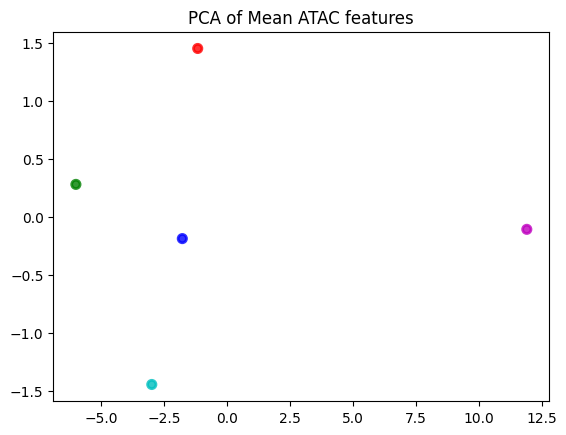

In [38]:
# build plot
colors = color_names[:len(days)]
lw = 2

plt.figure()
plt.scatter(features[:, 0], features[:, 1], color=colors, alpha=0.8, lw=lw, label=tags)
# plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of Mean ATAC features")

## Строим графики кластеров для неусредненных по дням значений

In [45]:
features_per_day = 200
cluster_features = []
cluster_tags = []

for dataset in all_data[1:]:
    for day in tqdm(days):
        dataset.reindex_dataset(day=day)
        random_ids = np.random.choice([i for i in range(len(dataset))], size=features_per_day)
        for ind in random_ids:
            cluster_features.append(dist_standardization(dataset[ind]['inputs']))
            cluster_tags.append(str(day))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.91it/s]


In [46]:
# build pca
pca = PCA(n_components=2)
features = pca.fit(cluster_features).transform(cluster_features)

Text(0.5, 1.0, 'PCA of ATAC features groups by day')

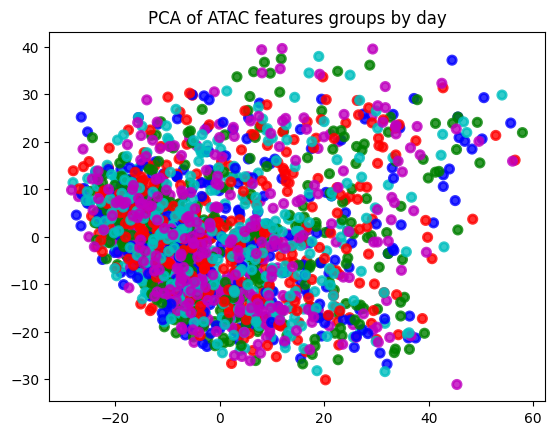

In [47]:
# build plot
colors_dict = {str(day): c for day, c in zip(days, color_names[:len(days)])}
colors = [colors_dict[day] for day in cluster_tags]

plt.figure()
plt.scatter(features[:, 0], features[:, 1], color=colors, alpha=0.8, lw=2, label=cluster_tags)
# plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of ATAC features groups by day")

-------------------------------------------

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.91it/s]


Text(0.5, 1.0, 'PCA of ATAC features groups by day')

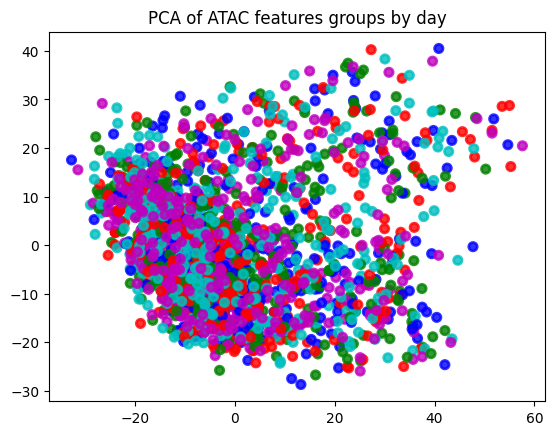

In [48]:
features_per_day = 200
cluster_features = []
cluster_tags = []

for dataset in all_data[1:]:
    for day in tqdm(days):
        dataset.reindex_dataset(day=day)
        random_ids = np.random.choice([i for i in range(len(dataset))], size=features_per_day)
        for ind in random_ids:
            cluster_features.append(dist_standardization(dataset[ind]['inputs']))
            cluster_tags.append(str(day))

# build pca
pca = PCA(n_components=2)
features = pca.fit(cluster_features).transform(cluster_features)

# build plot
colors_dict = {str(day): c for day, c in zip(days, color_names[:len(days)])}
colors = [colors_dict[day] for day in cluster_tags]

plt.figure()
plt.scatter(features[:, 0], features[:, 1], color=colors, alpha=0.8, lw=2, label=cluster_tags)
# plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of ATAC features groups by day")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.90it/s]


Text(0.5, 1.0, 'PCA of ATAC features groups by day')

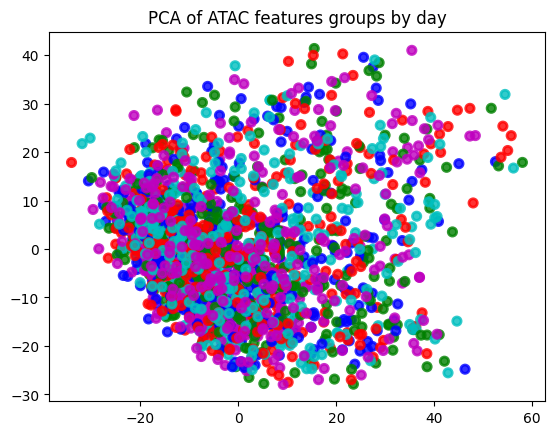

In [49]:
features_per_day = 200
cluster_features = []
cluster_tags = []

for dataset in all_data[1:]:
    for day in tqdm(days):
        dataset.reindex_dataset(day=day)
        random_ids = np.random.choice([i for i in range(len(dataset))], size=features_per_day)
        for ind in random_ids:
            cluster_features.append(dist_standardization(dataset[ind]['inputs']))
            cluster_tags.append(str(day))

# build pca
pca = PCA(n_components=2)
features = pca.fit(cluster_features).transform(cluster_features)

# build plot
colors_dict = {str(day): c for day, c in zip(days, color_names[:len(days)])}
colors = [colors_dict[day] for day in cluster_tags]

plt.figure()
plt.scatter(features[:, 0], features[:, 1], color=colors, alpha=0.8, lw=2, label=cluster_tags)
# plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of ATAC features groups by day")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.94it/s]


Text(0.5, 1.0, 'PCA of ATAC features groups by day')

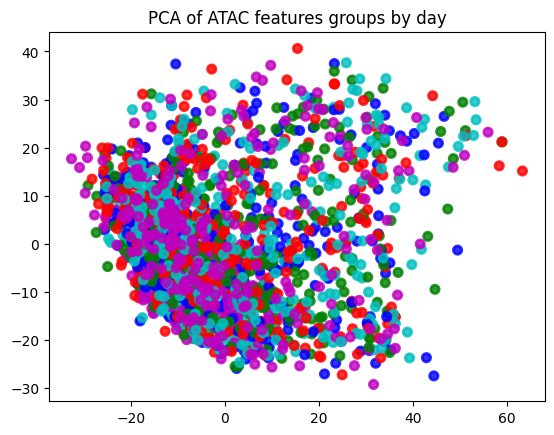

In [50]:
features_per_day = 200
cluster_features = []
cluster_tags = []

for dataset in all_data[1:]:
    for day in tqdm(days):
        dataset.reindex_dataset(day=day)
        random_ids = np.random.choice([i for i in range(len(dataset))], size=features_per_day)
        for ind in random_ids:
            cluster_features.append(dist_standardization(dataset[ind]['inputs']))
            cluster_tags.append(str(day))

# build pca
pca = PCA(n_components=2)
features = pca.fit(cluster_features).transform(cluster_features)

# build plot
colors_dict = {str(day): c for day, c in zip(days, color_names[:len(days)])}
colors = [colors_dict[day] for day in cluster_tags]

plt.figure()
plt.scatter(features[:, 0], features[:, 1], color=colors, alpha=0.8, lw=2, label=cluster_tags)
# plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of ATAC features groups by day")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.90it/s]


Text(0.5, 1.0, 'PCA of ATAC features groups by day')

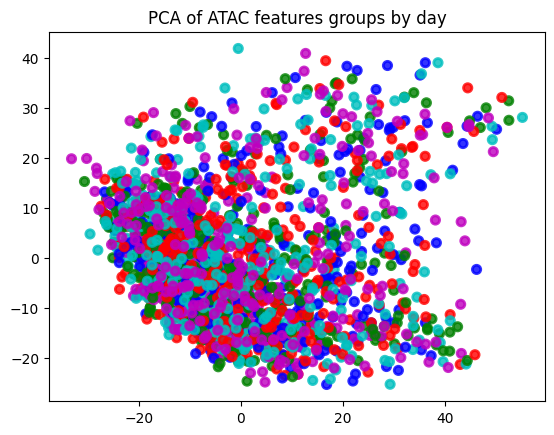

In [51]:
features_per_day = 200
cluster_features = []
cluster_tags = []

for dataset in all_data[1:]:
    for day in tqdm(days):
        dataset.reindex_dataset(day=day)
        random_ids = np.random.choice([i for i in range(len(dataset))], size=features_per_day)
        for ind in random_ids:
            cluster_features.append(dist_standardization(dataset[ind]['inputs']))
            cluster_tags.append(str(day))

# build pca
pca = PCA(n_components=2)
features = pca.fit(cluster_features).transform(cluster_features)

# build plot
colors_dict = {str(day): c for day, c in zip(days, color_names[:len(days)])}
colors = [colors_dict[day] for day in cluster_tags]

plt.figure()
plt.scatter(features[:, 0], features[:, 1], color=colors, alpha=0.8, lw=2, label=cluster_tags)
# plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of ATAC features groups by day")

--------------------------------------------------------------------------

## Строим кластера с усреднением случайных векторов по 10 штук

In [52]:
all_data = [dataset2, dataset3]

  0%|                                                                                                                                                                                                     | 0/5 [00:00<?, ?it/s]

[ Reading train_cite_inputs.h5 file ... ]
[ Reading train_cite_inputs.h5 file is complete. ]
[ Reading train_cite_targets.h5 file ... ]
[ Reading train_cite_targets.h5 file is complete. ]


 20%|█████████████████████████████████████▊                                                                                                                                                       | 1/5 [00:09<00:39,  9.77s/it]

[ Reading train_cite_inputs.h5 file ... ]
[ Reading train_cite_inputs.h5 file is complete. ]
[ Reading train_cite_targets.h5 file ... ]
[ Reading train_cite_targets.h5 file is complete. ]


 40%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                 | 2/5 [00:19<00:29,  9.77s/it]

[ Reading train_cite_inputs.h5 file ... ]
[ Reading train_cite_inputs.h5 file is complete. ]
[ Reading train_cite_targets.h5 file ... ]
[ Reading train_cite_targets.h5 file is complete. ]


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 3/5 [00:29<00:19,  9.83s/it]

[ Reading train_cite_inputs.h5 file ... ]
[ Reading train_cite_inputs.h5 file is complete. ]
[ Reading train_cite_targets.h5 file ... ]
[ Reading train_cite_targets.h5 file is complete. ]


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 4/5 [00:40<00:10, 10.16s/it]

[ Reading train_cite_inputs.h5 file ... ]
[ Reading train_cite_inputs.h5 file is complete. ]
[ Reading train_cite_targets.h5 file ... ]
[ Reading train_cite_targets.h5 file is complete. ]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.10s/it]


Text(0.5, 1.0, 'PCA of ATAC features groups by day')

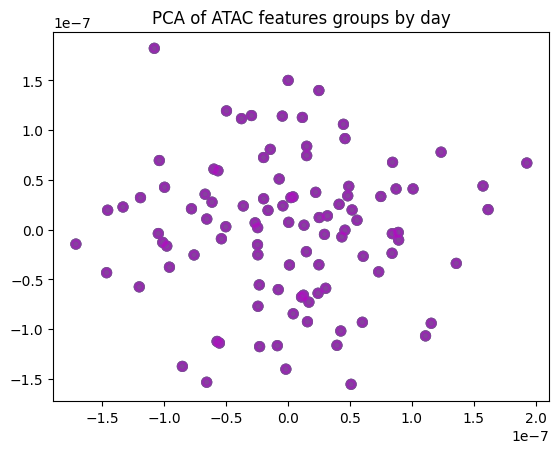

In [54]:
features_per_day = 10000
mean_count = 100
cluster_features = []
cluster_tags = []

for dataset in all_data[1:]:
    for day in tqdm(days):
        dataset.rebase('cite', mode)
        dataset.reindex_dataset(day=day)
        random_ids = np.random.choice([i for i in range(len(dataset))], size=features_per_day)
        for ind in range(features_per_day // mean_count): 
            cluster_features.append(np.mean(dist_standardization(dataset[ind * mean_count:(ind + 1) * mean_count]['inputs']), axis=1))
            cluster_tags.append(day)

# build pca
pca = PCA(n_components=2)
features = pca.fit(cluster_features).transform(cluster_features)

# build plot
colors_dict = {day: c for day, c in zip(days, color_names[:len(days)])}
colors = [colors_dict[day] for day in cluster_tags]

plt.figure()
plt.scatter(features[:, 0], features[:, 1], alpha=0.5, color=colors, lw=2, label=cluster_tags)
plt.title("PCA of ATAC features groups by day")

Text(0.5, 1.0, 'PCA of ATAC features groups by day')

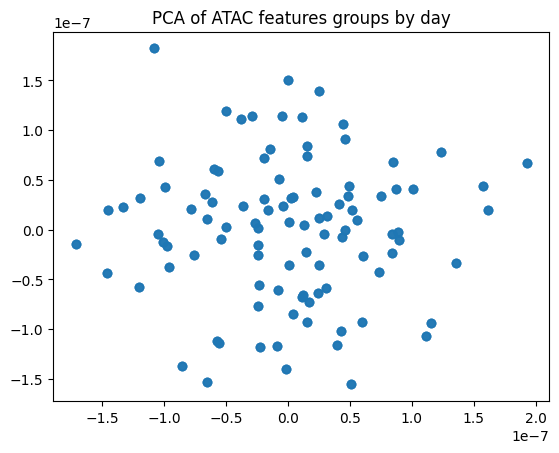

In [55]:
plt.scatter(features[:, 0], features[:, 1], alpha=0.5)
plt.title("PCA of ATAC features groups by day")

Text(0.5, 1.0, 'PCA of ATAC features groups by day')

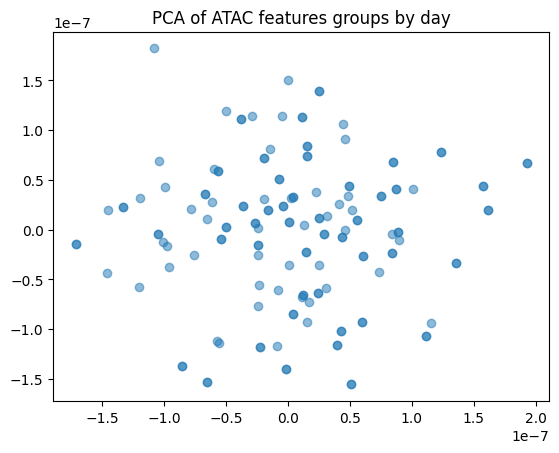

In [56]:
plt.scatter(features[:150, 0], features[:150, 1], alpha=0.5)
plt.title("PCA of ATAC features groups by day")